In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

# Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")


In [28]:
df = pd.read_csv("insurance.csv")
df.head()


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [29]:
df.shape

(1338, 7)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [31]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [32]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


### EDA

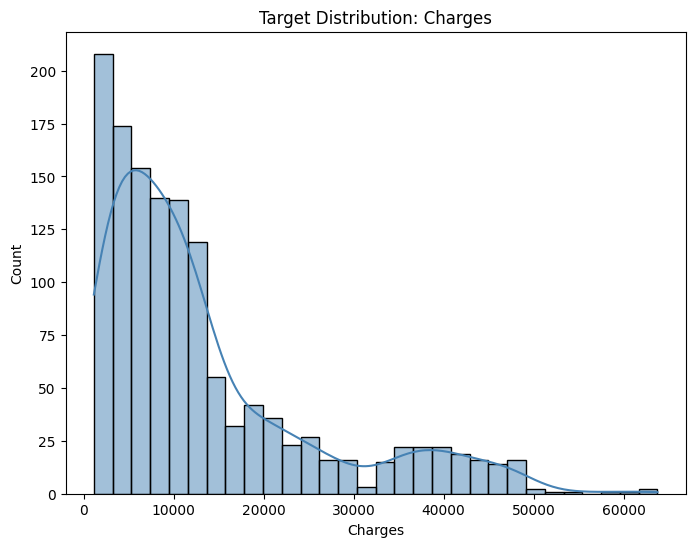

In [33]:
plt.figure(figsize=(8,6))
sns.histplot(df["charges"], kde=True, bins=30, color="steelblue")
plt.title("Target Distribution: Charges")
plt.xlabel("Charges")
plt.show()


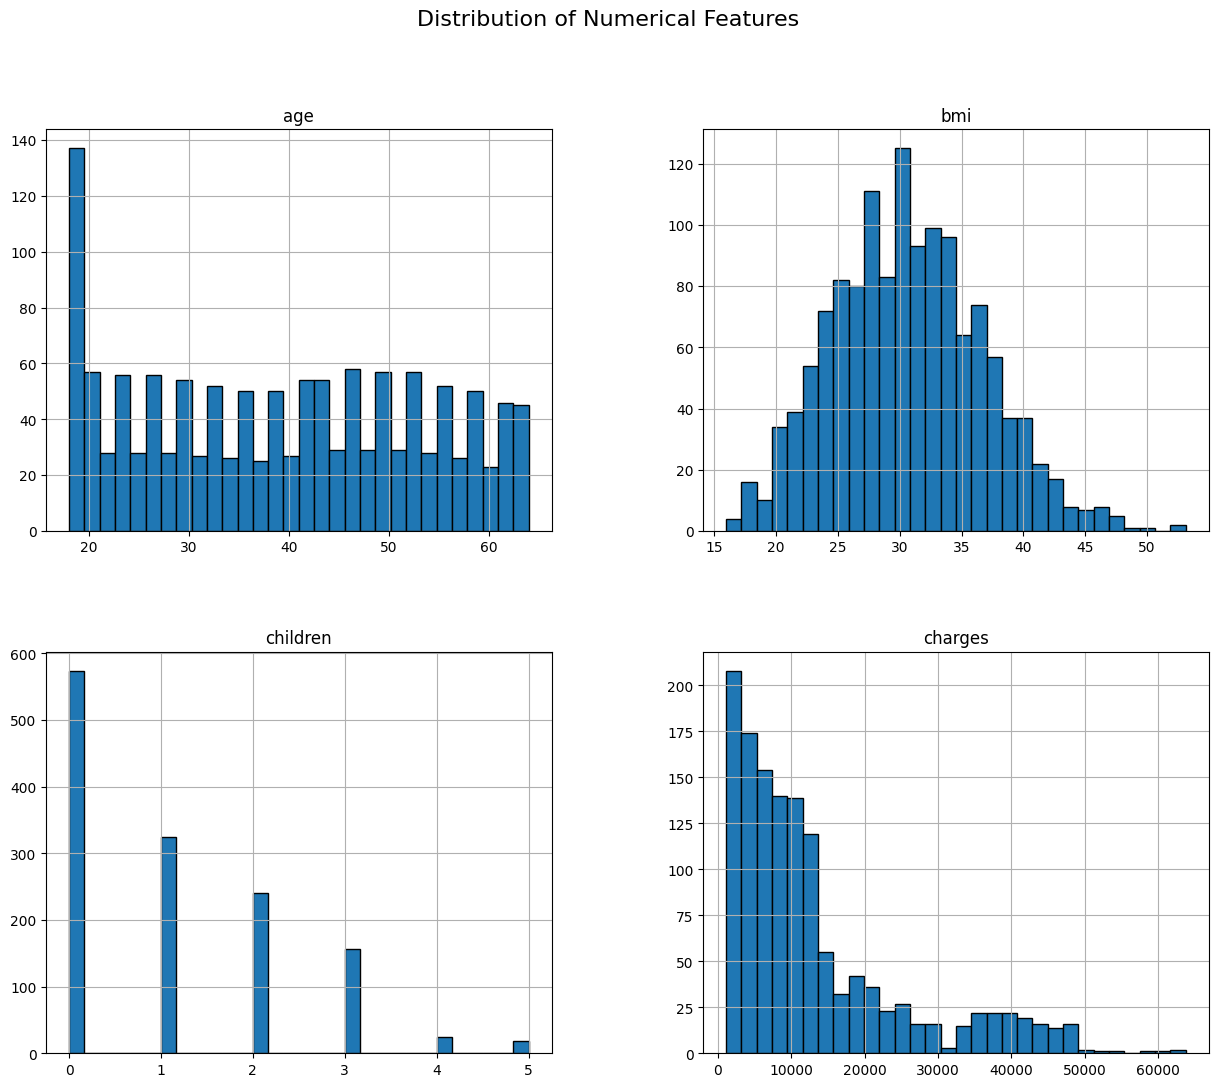

In [8]:
num_cols = df.select_dtypes(include=["int64","float64"]).columns
df[num_cols].hist(figsize=(15, 12), bins=30, edgecolor="black")
plt.suptitle("Distribution of Numerical Features", fontsize=16)
plt.show()


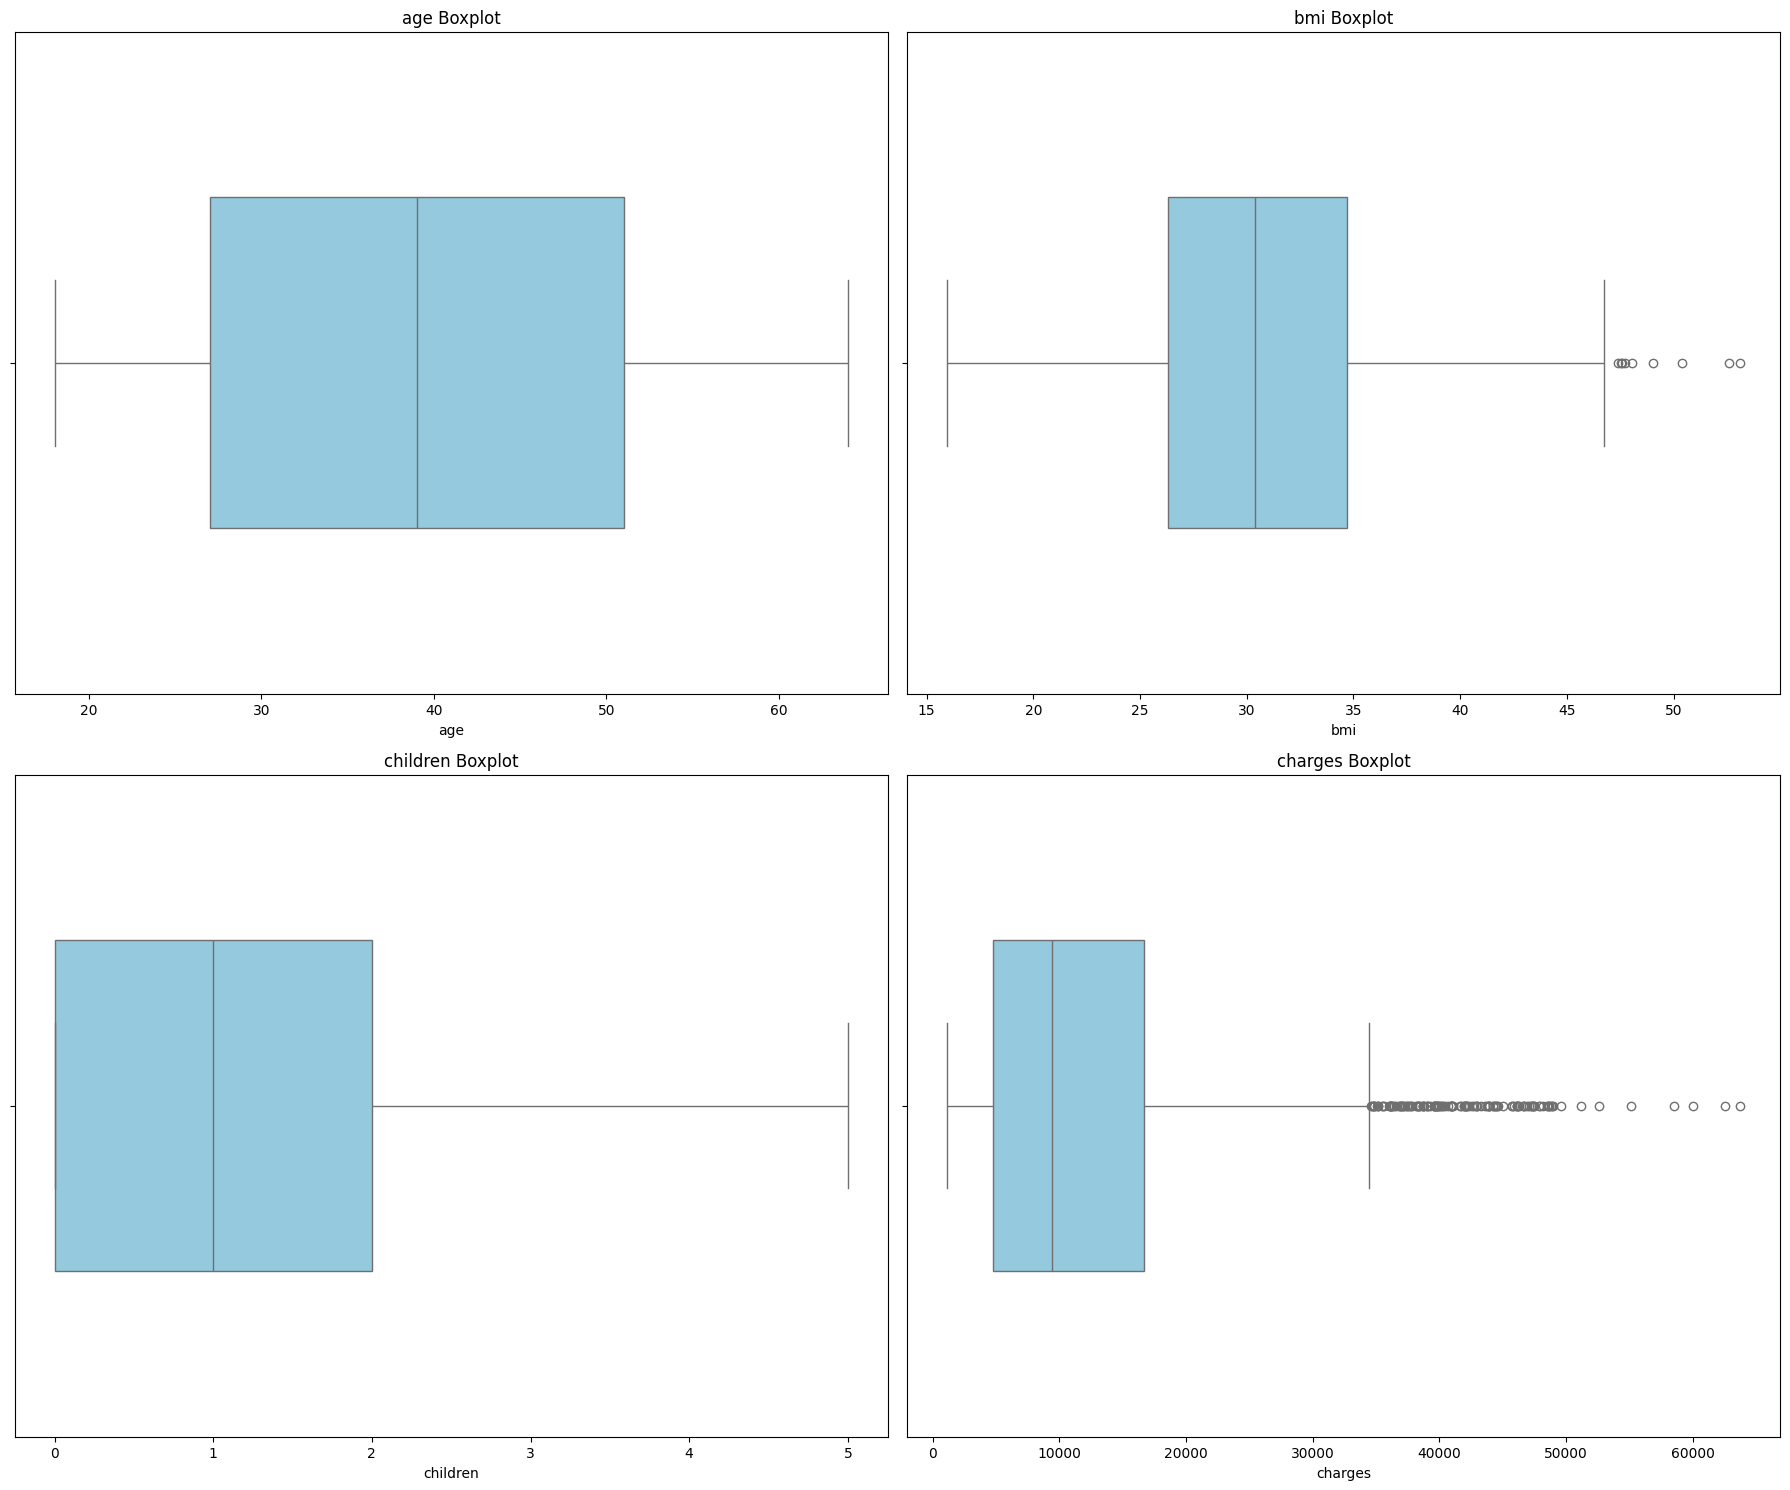

In [9]:
plt.figure(figsize=(18, 22))
for i, column in enumerate(num_cols, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(x=df[column], color="skyblue", width=0.5)
    plt.title(f"{column} Boxplot")
plt.tight_layout()
plt.show()


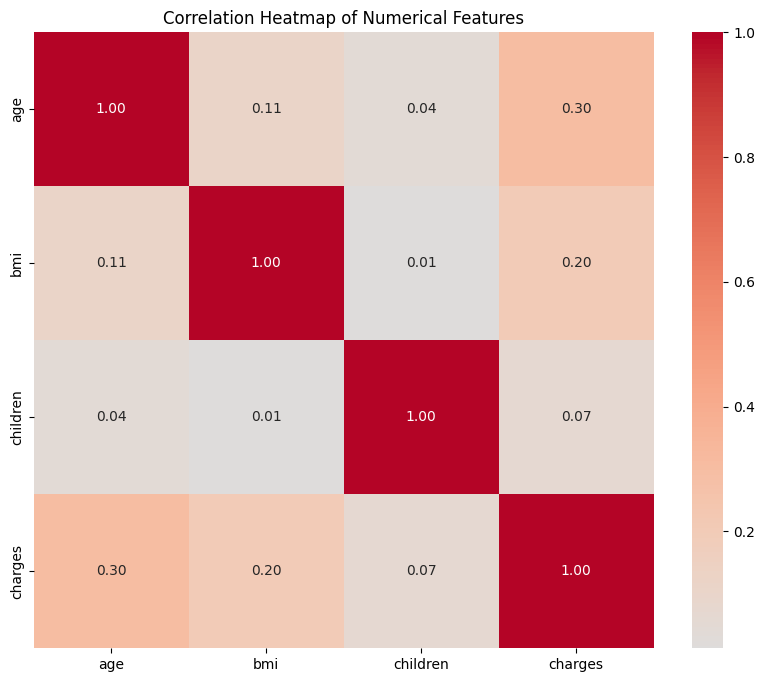

In [10]:
plt.figure(figsize=(10,8))
corr = df[num_cols].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Correlation Heatmap of Numerical Features")
plt.show()


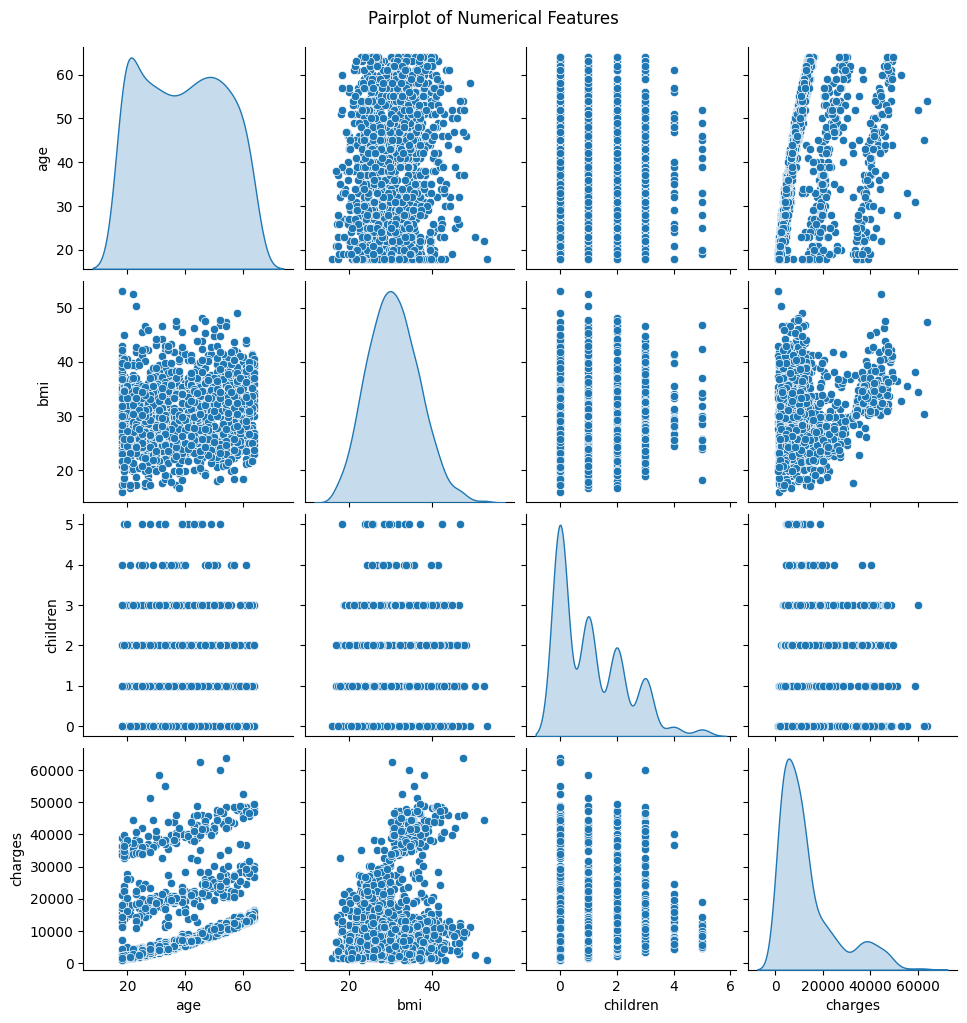

In [11]:
sns.pairplot(df[num_cols], diag_kind="kde")
plt.suptitle("Pairplot of Numerical Features", y=1.02)
plt.show()


In [34]:
cat_cols = ['sex','smoker','region']

ohe = OneHotEncoder(drop='first', sparse_output=False)
encoded_array = ohe.fit_transform(df[cat_cols])

# Convert to DataFrame
encoded_df = pd.DataFrame(encoded_array, 
                          columns=ohe.get_feature_names_out(cat_cols),
                          index=df.index)

# Merge back with original dataset
df_encoded = pd.concat([df.drop(columns=cat_cols), encoded_df], axis=1)

print("Encoded DataFrame:")
df_encoded.head()


Encoded DataFrame:


,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0.0,1.0,0.0,0.0,1.0
1,18,33.770,1,1725.55230,1.0,0.0,0.0,1.0,0.0
2,28,33.000,3,4449.46200,1.0,0.0,0.0,1.0,0.0
3,33,22.705,0,21984.47061,1.0,0.0,1.0,0.0,0.0
4,32,28.880,0,3866.85520,1.0,0.0,1.0,0.0,0.0


Train-Test Split

In [35]:
X = df_encoded.drop("charges", axis=1)
y = df_encoded["charges"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Training shape:", X_train.shape, y_train.shape)
print("Testing shape:", X_test.shape, y_test.shape)


Training shape: (936, 8) (936,)
Testing shape: (402, 8) (402,)


### Scaling According to Distribution

In [36]:
# Assign scalers manually based on distributions
scalers = {
    "age": StandardScaler(),       # ~ normal distribution
    "bmi": RobustScaler(),         # skewed, outliers
    "children": MinMaxScaler()     # small integer range
}

# Apply scalers
for col, scaler in scalers.items():
    X_train[[col]] = scaler.fit_transform(X_train[[col]])
    X_test[[col]] = scaler.transform(X_test[[col]])


In [44]:
from sklearn.pipeline import Pipeline

# Numeric columns
num_cols = ['age','bmi','children']

# Assign scalers based on distribution
scalers = {
    "age": StandardScaler(),     # ~ normal
    "bmi": RobustScaler(),       # skewed, outliers
    "children": MinMaxScaler()   # small integer
}

# Build pipelines for scalers
scaler_pipes = {col: Pipeline([("scaler", scalers[col])]) for col in num_cols}

# Apply pipelines
for col, pipe in scaler_pipes.items():
    X_train[[col]] = pipe.fit_transform(X_train[[col]])
    X_test[[col]] = pipe.transform(X_test[[col]])


Train Models

In [37]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0, random_state=42),
    "Lasso Regression": Lasso(alpha=0.001, random_state=42),
    "Elastic Net": ElasticNet(alpha=0.001, l1_ratio=0.5, random_state=42)
}

trained_models = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    trained_models[name] = model


Training Linear Regression...
Training Ridge Regression...
Training Lasso Regression...
Training Elastic Net...


In [47]:
models = {
    "Linear Regression": Pipeline([("model", LinearRegression())]),
    "Ridge Regression": Pipeline([("model", Ridge(alpha=1.0, random_state=42))]),
    "Lasso Regression": Pipeline([("model", Lasso(alpha=0.001, random_state=42))]),
    "Elastic Net": Pipeline([("model", ElasticNet(alpha=0.001, l1_ratio=0.5, random_state=42))])
}

trained_models = {}

for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    trained_models[name] = pipe
    print(f"Training {name}...")


Training Linear Regression...
Training Ridge Regression...
Training Lasso Regression...
Training Elastic Net...


In [46]:
results = {}

for name, model in trained_models.items():
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    results[name] = {
        "Train MAE": mean_absolute_error(y_train, y_train_pred),
        "Test MAE": mean_absolute_error(y_test, y_test_pred),
        "Train RMSE": np.sqrt(mean_squared_error(y_train, y_train_pred)),
        "Test RMSE": np.sqrt(mean_squared_error(y_test, y_test_pred)),
        "Train R2": r2_score(y_train, y_train_pred),
        "Test R2": r2_score(y_test, y_test_pred)
    }

results_df = pd.DataFrame(results).T
results_df


,Train MAE,Test MAE,Train RMSE,Test RMSE,Train R2,Test R2
Linear Regression,4251.255799,4145.450556,6142.519819,5812.100272,0.742398,0.769612
Ridge Regression,4260.766205,4157.834191,6142.844521,5815.367527,0.742371,0.769353
Lasso Regression,4251.255805,4145.450822,6142.519819,5812.100280,0.742398,0.769612
Elastic Net,4255.689536,4151.248145,6142.591455,5813.555903,0.742392,0.769496


In [43]:
# Select best model based on lowest Test MAE
best_model_name = results_df["Test MAE"].idxmin()
best_model = trained_models[best_model_name]

print(f" Best Model: {best_model_name}")


 Best Model: Linear Regression


Feature Importance (Coefficients)

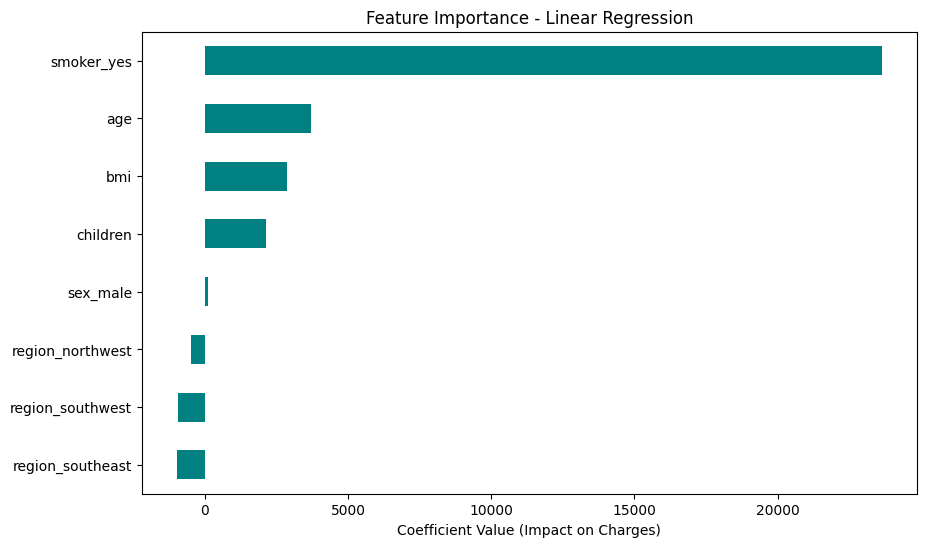

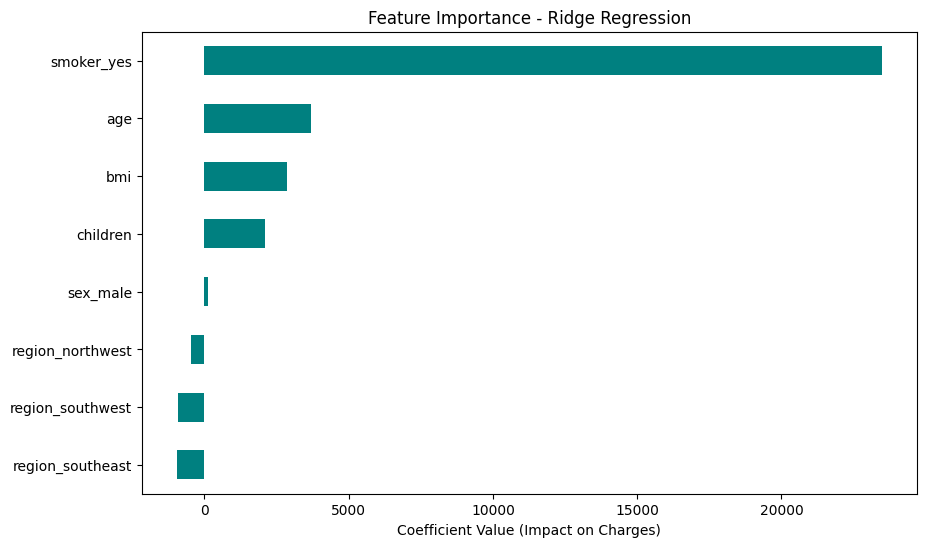

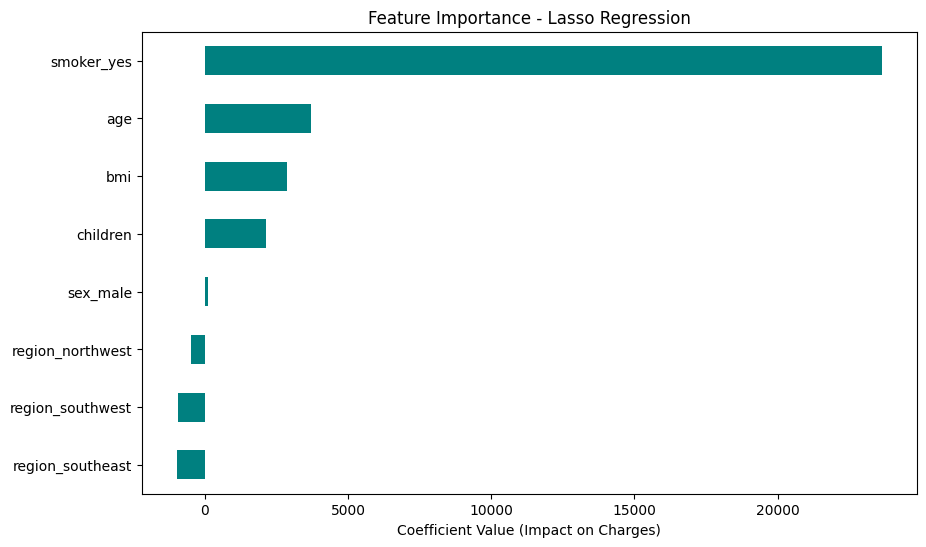

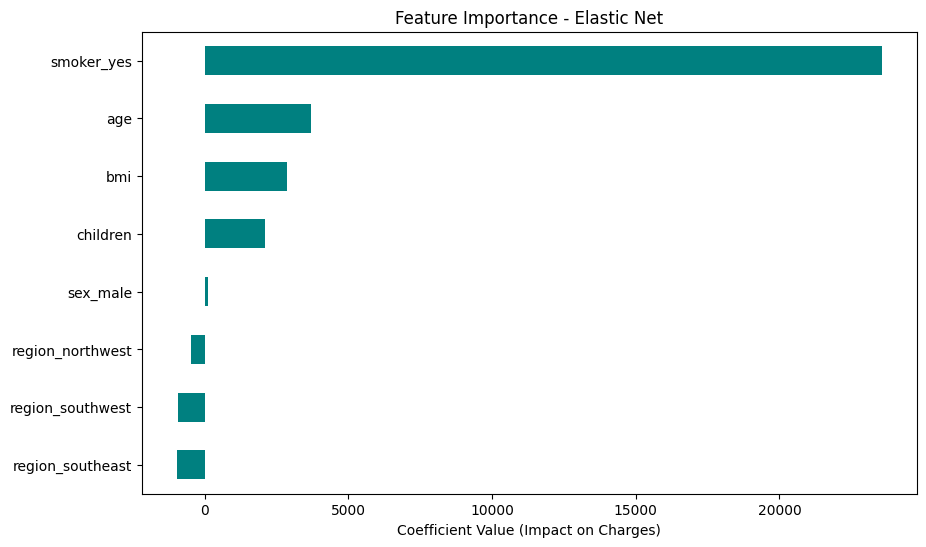

In [40]:
# Get feature names (after encoding + scaling)
feature_names = X_train.columns  

coef_df = {}

for name, model in trained_models.items():
    if hasattr(model, "coef_"):   # Only linear-type models
        coefs = pd.Series(model.coef_, index=feature_names)
        coef_df[name] = coefs

        # Plot coefficients
        plt.figure(figsize=(10,6))
        coefs.sort_values().plot(kind="barh", color="teal")
        plt.title(f"Feature Importance - {name}")
        plt.xlabel("Coefficient Value (Impact on Charges)")
        plt.show()


### Compare Models Visually

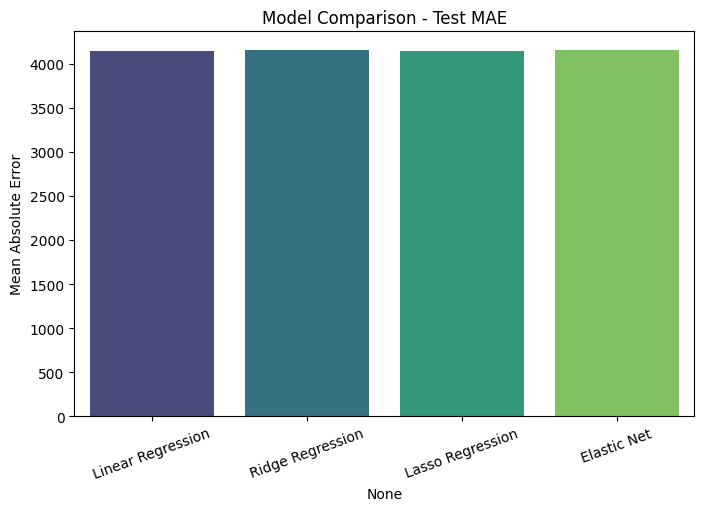

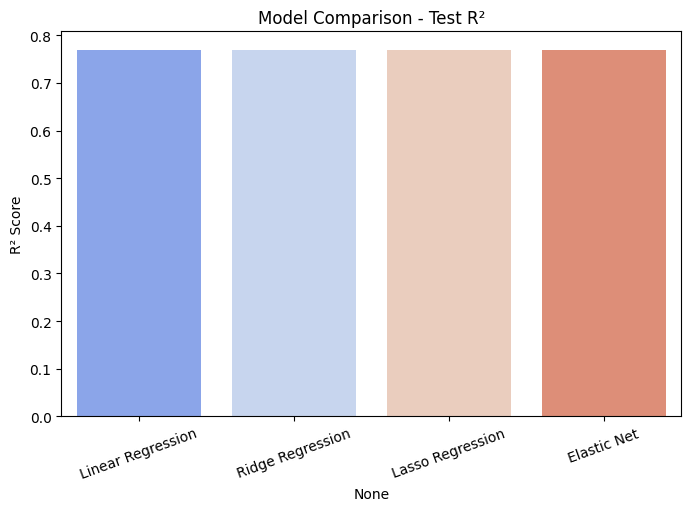

In [41]:
# Compare Test MAE visually
plt.figure(figsize=(8,5))
sns.barplot(x=results_df.index, y=results_df["Test MAE"], palette="viridis")
plt.title("Model Comparison - Test MAE")
plt.ylabel("Mean Absolute Error")
plt.xticks(rotation=20)
plt.show()

# Compare Test R² visually
plt.figure(figsize=(8,5))
sns.barplot(x=results_df.index, y=results_df["Test R2"], palette="coolwarm")
plt.title("Model Comparison - Test R²")
plt.ylabel("R² Score")
plt.xticks(rotation=20)
plt.show()
